# EVCSAP Stochastic Programming - Nr CPs validation Test
*Author: Gen LI; Date: 14.11.22*


In [1]:
# Import local scripts
 
# import src.c.d

import os, sys
currentdir = os.path.dirname(os.path.realpath(''))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from csap_packages_sp import sp_data_process as Dap
# from csap_packages_sp import sp_model_setup as Sup
from csap_packages_sp import sp_model_setup_by_fm_data as SupSP
from csap_packages_sp import sp_stat_compu as Stac
from csap_packages_sp import sp_sce_generation as Sceg
from csap_packages_sp.sp_mpd_frame_model_setup import _build_mpdp_csap_frame


# Import Opensource packages
import idaes
import numpy as np
import pandas as pd
import geopandas as gpd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyproj import CRS
from shapely.geometry import Point, MultiPoint
import matplotlib.pyplot as plt
from tqdm import tqdm
from cProfile import label
import plotly.express as px
from pyomo.core.expr.current import evaluate_expression
import time
import pickle
import seaborn
from mpisppy.opt.ef import ExtensiveForm
from datetime import datetime

# seaborn.set_theme(context = 'notebook', style = 'whitegrid')

# np.random.seed(121022)
# currentdir, parentdir

[    0.00] Initializing mpi-sppy


In [2]:
currentdir, parentdir

('C:\\Users\\z004ffpm\\Work_Documents\\CSallocModel\\model_evcsap\\stochastic_model\\Validation_02_Dec',
 'C:\\Users\\z004ffpm\\Work_Documents\\CSallocModel\\model_evcsap\\stochastic_model')

## Section 1: Pre-process Geo-data to get Setup Dictionary for pyomo model

In [3]:
#########################################################
#### Load Data from OSM, Sythetic, OCM, DE Bundesamt #### 

# --- Load Schutter Wald OSM Data (Resource from hdgb API by Domenico) --- # 
geojson_folder = r"C:\Users\z004ffpm\Work_Documents\MyExtractedData\hdgb\77746\geojson"
geojson_filename = r"\evcsap_77746_ss.geojson"

filepath = geojson_folder + geojson_filename
SW_gdf = gpd.read_file(filepath)

# --- Load Synthetic Substations Data for SW (Resource from Domenico) --- #
path_synthetic_ss_SW =  r"C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Data\SW_transformers.csv"
df = pd.read_csv(path_synthetic_ss_SW)
df['element'] = 'substations' # We keep the 'tag' == 'transformers', for later reference that these data are synthetic
syn_ss_SW_gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.lon, df.lat)
)

# --- Load existing old CSs from OCM --- #
# # There's no CS data for Schutterwald on OCM, thus jump this step. (Resouce from Sisi)
# df_ocm = pd.read_csv('./ocm.csv')

# --- Load existing old CSs from "Ladesaeulenregistered" by DE Bundesamt --- #
df_DE_Gov = pd.read_csv(
    r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Ladesaeulenregister_CSV.csv', 
    encoding = "ISO-8859-1", # "utf-8", 
    header = 10, 
    sep = ';'
    )
# df_DE_Gov.head(3)
oldCS_df_SW = df_DE_Gov[df_DE_Gov.Postleitzahl == 77746] # EDEKA Oberle Getränkemarkt

#########################################################################################
#### Process loaded data, define single-period and multi-period deterministic data ######

# --- concat OSM and Synthetic data for SW --- #
SW_concat_gdf = gpd.GeoDataFrame(pd.concat([SW_gdf, syn_ss_SW_gdf], axis=0, ignore_index=True))

# --- Pre-process concatted data --- #
gdfcopy = SW_concat_gdf.copy()

# Calculate centroids by merging data with same id. 
gdfcopy = Dap._get_centered_gdf(gdfcopy)

# # Get parking and charging_station info from `df['tag']` to define candidate locations for new CSs
gdfcopy = Dap._detect_parking_CS_SS(gdfcopy)

# --- Insert Bundesnetzagentur data to concatted DataFrame --- #
lat_sw = float(oldCS_df_SW.loc[4012, 'Breitengrad'].replace(',', '.'))
lon_sw = float(oldCS_df_SW.loc[4012, 'Längengrad'].replace(',', '.'))
geo_array = np.array([lon_sw, lat_sw])
gdfcopy.loc[len(gdfcopy)] = {
    'osm_id': 'regisID_4012',
    'element': 'charging_station',
    'tag': "{'amenity': 'charging_station', \
            'Source': 'Bundesnetzagentur'}",
    'geometry': Point(lon_sw,lat_sw),
    'lat': lat_sw,
    'lon': lon_sw,
    'id_count': 1,
    'parking_capacity': None,
    'max_extraCPsToInstall': 2,
    'charging_capacity': 2,
    } # Useful Reference: https://gis.stackexchange.com/questions/345167/building-geodataframe-row-by-row


# --- Build multi-period POI statistics Dataframe  --- # 
### Define statistics by sampling from Poisson/Beta/Normal distributions. 
### These data are treated as known info to EVCSAP model 
np.random.seed(151222)
dict_POI_Statistics = {
    'day_normal':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 80, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.45, 0.1)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.25, 0.05)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.75, 0.1)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 130, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.55, 0.1)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (1, 0.15)
            }
    },
    'day_peak':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 30, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (25/60, 6/60)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 7, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (15/60, 3/60)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (45/60, 6/60)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 40, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (35/60, 6/60)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 25, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (60/60, 9/60)
        }
    },
    'night':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 5, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (420/60, 45/60)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 3, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (360/60, 45/60)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 5, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (420/60, 45/60)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 3, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (330/60, 75/60)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 3, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (420/60, 60/60)
        }        
    }
}
### Build POIs stat df
df_SW_POI_stat_mpd = Dap._assign_mp_POI_statistics(
    gdf = gdfcopy, dict_POI_Statistics = dict_POI_Statistics
)


# --- Build multi-period Substations Statistics Dataframe --- # 
### Define statistics by sampling from normal distributions. 
### These data are treated as known info to EVCSAP model 
avg_SS_full_load_cap = 400
dict_mpd_SW_SS_Statistics = { # The only substation statistics to define is the available power load (on avg.) during different periods 
    'day_normal': (0.2*avg_SS_full_load_cap, 0), # means the available power load follows a normal distribution with (mean = 80, std = 0)
    'day_peak': (0.12*avg_SS_full_load_cap, 0),
    'night': (0.3*avg_SS_full_load_cap, 0)
}
### Build SSs stat df
df_SW_SS_stat_mpd = Dap._assign_mp_SS_statistics(
    gdf = gdfcopy, dict_mpd_SS_Statistics = dict_mpd_SW_SS_Statistics
)



Extracting parking info from gdf["tag"]: 100%|████████████████████████████████████| 195/195 [00:00<00:00, 12478.10it/s]
C:\Users\z004ffpm\Anaconda3\envs\OptPyomoSP\lib\site-packages\pandas\core\construction.py:762: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
Assigning SS statistics: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.32it/s]


In [5]:
# # Identify indicies for different nodes
# id_candi_locs2update = gdfcopy[gdfcopy['element'] == 'charging_station'].index
# id_candi_locs2buildNew = gdfcopy[gdfcopy['element'] == 'parking'].index
# id_candi_locs_total = id_candi_locs2update.union(id_candi_locs2buildNew)

# id_substations = gdfcopy[gdfcopy['element'] == 'substations'].index

# id_cd_centers = gdfcopy.loc[(gdfcopy['element'] != 'parking') \
#         & (gdfcopy['element'] != 'charging_station') \
#             & (gdfcopy['element'] != 'substations')
#         , :].index
# id_CS_SS = gdfcopy.loc[(gdfcopy['element'] == 'parking') \
#         | (gdfcopy['element'] == 'charging_station') \
#             | (gdfcopy['element'] == 'substations')
#         , :].index

In [7]:
#########################################################
####      Get Model Setup Strategy dictionary      ######
# Define Strategy dictionary for other non-osm/ocm/synthetic... parameters
strategy_dict = {
    # ----- CS ----- #
    'cost_buildNewCS': 3000, # float, annuity of updating an old opened CS
    'cost_updateOldCS': 2500, # float, annuity of updating an old opened CS
    'cost_installCP': 2250, # float, annuity of installing a CP

    'profit_charge_fee': (0.51, 0.00), # set as normal Distrib. (mean, std), charging fee at CS euro/kWh
    'budget_max_N_newBuildCS' : 8, # int, max amount of new CSs the investors want to open
    'budget_max_N_updateCS' : 1, # int, max amount of old CSs investors want to update
    'budget_max_N_totalCSs' : 8, # int, max amount of CSs (old or new) to update or open in total:
    'budget_max_N_new_CPs' : 10, # int, max amount of new CPs investors want to install
    'rule_Min_dist_Between_CSs' : 2/60, # float in hour, min distance allowed between two CSs
    'config_CPpower' : 22, # float, in kW, Power rating of a CP,
    
    # ----- SS ----- #
    'cost_expandSS': 500, # float, annuity of substation powerload expansion per KW.     
        # Since domain of grid decision variables can be: [0, 100, 200,...], 
        # every expansion cost then can be in the unit of €/100kW
    'cost_backstopTech': 5, # float, one time cost of using backstop tech per KW to prevent overload blackout
        # This is one time cost, and domain of backstop tech usage decision variables is: [0, 100, 200,...], 
        # which means every usage of backstop tech is in the unit of (365 * €/100kW ) 
    ## ---- Stochastic scenario generation ---- ##
    'max_dist_cs_ss_connection': 6/60, # float in hour, walking distance (5km/hour) -> 6/60 * 5000 = 500 m        
    'CS_neighbour_dist_decay_threshold': 4/60, # float in hour, walking distance (5km/hour) 
        # # used for calculating dist_decay between CSs to adjust "neighbours' connection reward weights"
        # # 'CS_neighbour_dist_decay_threshold' > 'rule_Min_dist_Between_CSs'
    
    # ----- CD ----- #    
    'rule_dist_decay_threshold' : 5/60, #10/60 # float in hour, max walking dist EV drivers can tolerate to charge their EVs    
    'config_Battery_cap': 50, # float, in kWh, battery capacities of EVs
    'config_periods_length': {
        'day_normal': 10, # 08:00~17:30; 19:30~20:00
        'day_peak': 2, # 17:30~19:30
        'night': 12 # 20:00~00:00
    },        
}

# Get setup dictionary for auxilliary model 
csap_setup_dict_4_auxi, gdf_4_auxi = Dap._get_ModelSetupDict(
    gdf = gdfcopy, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd
)

# Set up auxilliary model 
# and get (gdf, substations_stat_df) after droping isolated nodes
auxi_model_2_drop_islt_nodes = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict_4_auxi
    )

gdfcopy_dropped_isolated, df_SW_SS_stat_mpd_dropped_isolated = \
    Dap._get_dfs_with_isolated_nodes_dropped(
        auxilliary_model = auxi_model_2_drop_islt_nodes, 
        origin_gdf = gdfcopy, 
        origin_SS_stat_df = df_SW_SS_stat_mpd
    )

# Get the formal Set-up dictionary for generating scenarios and set-up model
csap_setup_dict, final_gdf = Dap._get_ModelSetupDict(
    gdf = gdfcopy_dropped_isolated, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd_dropped_isolated
)
print("Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe ")


# import pickle 
# with open('csap_setup_vali_dict_23Nov.pickle', 'wb') as f:
#     pickle.dump(csap_setup_dict, f)
# 
# csap_setup_dict = pd.read_pickle('dict_mpsp_setup_vali_23Nov.pickle')

Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.23 seconds.
Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 
Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 


In [8]:
# save_fig = False
# Dap.geo_visualizer(final_gdf, save_fig) 

In [9]:
# with open('0412__convergence_another_test_setup_dict.pickle', 'wb') as f:
#     pickle.dump(csap_setup_dict, f)

## Section 2: Generate Random Scenarios for CS-SS Connection

In [10]:
now_time = datetime.now()
now_string = now_time.strftime("%d%m_%H_%M")

In [11]:
mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')

In [12]:
copy_csap_setup_dict = csap_setup_dict #.get('params_cd').

In [13]:
Solver = SolverFactory(
#     'glpk'
#     'ipopt'
    'cplex'
#     'gams'
#     'cplex_direct'
#     'bonmin'
    # 'couenne'
    , tee = True, 
)

In [83]:
from csap_packages_sp.sp_model_setup_by_fm_data import _get_data_from_frame_model

# _get_data_from_solved_mpdp(
#         solver_results = test_results, #results_NO_service_time_cap,
#         solved_model = mpdp_frame_model_4_sp,    
#     )

In [18]:
copy_csap_setup_dict['params_basic']['N_newBuild'] = 12
copy_csap_setup_dict['params_basic']['N_totalCSs'] = 13

In [20]:
copy_csap_setup_dict['params_basic'].keys()

dict_keys(['cs_ss_nodes', 'nodes', 'N_newBuild', 'N_update', 'N_totalCSs', 'N_newCPs', 'DeltaT', 'rho'])

In [22]:
mpdp_frame_model_4_sp = _build_mpdp_csap_frame(    
    setup_dict = copy_csap_setup_dict, 
    cs_ss_connect_sce = mpdp_connection_sce.stack().to_dict(),
    m_name = model_name, 
    linearized = linearize_csap
)
mpdp_frame_model_4_sp.obj_cost_no_grid.deactivate()
mpdp_frame_model_4_sp.obj_total_cost.activate()
mpdp_frame_model_4_sp.cons_grid_load_efficientCD.activate()
mpdp_frame_model_4_sp.cons_grid_load_NrCPs.deactivate()


Built an empty concrete pyomo model named mpdp_frame_model_4_sp. 
Defining sets   ...
Parameters_setup 1: Feeding basic parameters to mpdp_frame_model_4_sp ...
Parameters_setup 2: Feeding CS parameters  to 'mpdp_frame_model_4_sp' ...
Parameters_setup 3: Feeding SS parameters to 'mpdp_frame_model_4_sp' ... 
Parameters_setup 4: Feeding CD parameters to mpdp_frame_model_4_sp ... 
 ... 
   Calculating walking distances between candidate locations and CD centers: model.d ...
     Done! Process took 0.73 seconds.
All CD parameters fed! 

Feeding cs-ss connection scenario to model ... 
Feeding decision variables ... 
Defining Expression of Exogenous (Charging) Energy Supply Capability of CSs ...
 Done! Process took 71.42 seconds.
Feeding objective to mpdp_frame_model_4_sp ...

          There are two objectives 'obj_total_cost' and 'obj_cost_no_grid' in frame model.
          Before resolution, use method:
    `model.objective_name.deactive()` to deactive one of them and solve the model with 

In [24]:
frame_model_data = SupSP._get_data_from_frame_model(mpdp_frame_model_4_sp)

In [65]:
test_results_df = pd.DataFrame(index = test_results_dict.keys(), columns = ['Annual Profit', 'SSs Expansion Cost'])
test_results_df

,Annual Profit,SSs Expansion Cost
NrCPs_10,NaN,NaN
NrCPs_20,NaN,NaN
NrCPs_30,NaN,NaN
NrCPs_40,NaN,NaN
NrCPs_50,NaN,NaN
NrCPs_60,NaN,NaN
NrCPs_70,NaN,NaN
NrCPs_80,NaN,NaN
NrCPs_90,NaN,NaN
NrCPs_100,NaN,NaN


In [66]:
for idx in test_results_df.index:
    test_results_df.loc[idx,'Annual Profit'] = test_results_dict[idx]['obj_total_cost']
    test_results_df.loc[idx, 'SSs Expansion Cost'] = test_results_dict[idx]['grid_expansion_cost']
    test_results_df.loc[idx, 'Nr CPs installed'] = sum(test_results_dict[idx]['solved_model_data']['y'].values())

In [68]:
test_results_dict[idx]['solved_model_data']['y']

{195: 2.0,
 18: 0.0,
 36: 2.0,
 48: 10.0,
 58: 8.0,
 61: 8.0,
 96: 8.0,
 110: 8.0,
 114: 16.0,
 115: 12.0,
 177: 0.0,
 178: 26.0}

In [67]:
test_results_df

,Annual Profit,SSs Expansion Cost,Nr CPs installed
NrCPs_10,-324504.601133,0.0,10.0
NrCPs_20,-557617.662146,50000.0,20.0
NrCPs_30,-781776.448696,100000.0,30.0
NrCPs_40,-989672.446343,150000.0,40.0
NrCPs_50,-1192710.620767,200000.0,50.0
NrCPs_60,-1374906.485316,250000.0,60.0
NrCPs_70,-1510060.708092,275000.0,70.0
NrCPs_80,-1621546.011555,300000.0,80.0
NrCPs_90,-1715079.821971,300000.0,90.0
NrCPs_100,-1770332.461114,375000.0,100.0


In [53]:
test_results_dict['NrCPs_10']['obj_total_cost']

{'obj_total_cost': -324504.6011334248,
 'cs_placement_cost': 31500.0,
 'grid_expansion_cost': 0.0,
 'backstop_tech_cost_sp': 0.0,
 'gross_revenue': 356004.6011334248,
 'first_stage_cost': -324504.6011334248,
 'prob_description': {'Lower bound': -324504.6011334248,
  'Upper bound': -324504.6011334248,
  'Number of constraints': 3486,
  'Number of variables': 6842},
 'solver_info': {'User time': 0.31,
  'Termination message': 'MIP - Integer optimal solution\\x3a Objective = -3.2450460113e+05',
  'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}},
  'Time': 0.4726250171661377},
 'solved_model_data': {'I_update': [195],
  'I_newBuild': [18, 36, 48, 58, 61, 96, 110, 114, 115, 177, 178],
  'I': [195, 18, 36, 48, 58, 61, 96, 110, 114, 115, 177, 178],
  'J': [15,
   16,
   17,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   37,
   38,
   39,
   40,
   41,
   42,
 

In [62]:
sum(test_results_dict['NrCPs_10']['solved_model_data']['y'].values())

10.0

In [45]:
now_string

'1001_16_56'

In [46]:
# with open(f'Nr_CPs_test_results_dict_{now_string}.pickle', 'wb') as f:
#     pickle.dump(test_results_dict, f)        


In [ ]:
test_results_dict

In [ ]:
NrCPs_list = [n for n in range(10, 180, 10)]
# NrCPs_list = [n for n in range(10, 30, 10)]
# str_phi_IJ_list = [f'{i}/60' for i in range(3,11)]
# float_phi_IJ_list = [i/60 for i in range(3,11)]
test_results_dict = dict()

for idx, NrCPs in enumerate(NrCPs_list):
    print('---------------------------')
    print(f"NrCPs = {NrCPs} test starts ... ")
    frame_model_data['N_newCPs'] = NrCPs_list[idx]
    model_name = 'MPDP_by_frame_data' # assign name to pyomo model, default name set in the setup function is 'CSAP'
    csap_is_solved = False
    linearize_csap = True

    print("Building MPDP model by frame data ... ")
    MPDP_by_frame_data = SupSP._build_mpsp_csap_from_mpdp_frame(
        mpdp_frame_data = frame_model_data, # test_results_dict[f'phi_IJ_{i}/60']['solved_model_data'],
        cs_ss_connect_sce = mpdp_connection_sce.stack().to_dict()
    )
    
    test_results = Solver.solve(MPDP_by_frame_data)
    csap_is_solved = True    
        ## Store results in the dict

    print("Storing test results ... ")
    test_result_and_model_data_dict = Stac._get_data_from_solved_mpdp(
        solver_results = test_results, #results_NO_service_time_cap,
        solved_model = MPDP_by_frame_data,    
    )
    test_results_dict[f'NrCPs_{NrCPs}'] = test_result_and_model_data_dict
#     results_prob_descrip = test_results['Problem'][0]
    results_solver_info = test_results['Solver'][0]
#     current_obj_val = test_results['Solution'][0]['Objective']['__default_objective__']['Value']
    
    ## Store CSAP decisions

#     test_result_dict[idx] = {
# #         'num_scenarios': num_sces,
# #         'ids_scenarios': selected_sces_names,
#         'objective_value' : current_obj_val,
#         'prob_description': {key: results_prob_descrip[key] for key in useful_description_info_list },
#         'solver_info' : {key: results_solver_info[key] for key in useful_solver_info_list},
#         'gap' : results['Solution'][0]['Gap'], 
#         'one_subsceModel_data' : model_data
#         # 'mpsp_csap_decisions': mpsp_decisions 
#     }
    print('Done')
    
    print(f"Results of NrCPs = {NrCPs} is: {results_solver_info['Termination message']}")
    # print(f"Results for \n", test_results)
    print_decision = True
    if print_decision:
        Stac._print_decision(MPDP_by_frame_data)
        
    print('---------------------------')    
    
#     hourly_CD_cover_each_CP_at_CSs, Nr_CPs = \
#         _get_hourly_CD_cover_each_CP_atCSs(mpdp_frame_model_4_sp)    

---------------------------
NrCPs = 10 test starts ... 
Done! set up MPSP_CSAP took 1.31 seconds.

Storing test results ... 
Done
---------------------------------------

Results of NrCPs = 10 is: MIP - Integer optimal solution\x3a Objective = -3.2450460113e+05
Decision to build new CSs, 
(loc_id, Nr_CP): 
[(48, 3.0), (61, 2.0), (110, 5.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_CPs): 
[]
Decision to expand SSs, 
(loc_id, size_expansion): 
[]

Decision to use expensive backstop tech at SSs, 
((loc_id, period), amount_backstop usage): 
[]

---------------------------
---------------------------
NrCPs = 20 test starts ... 
Done! set up MPSP_CSAP took 2.21 seconds.

Storing test results ... 
Done
---------------------------------------

Results of NrCPs = 20 is: MIP - Integer optimal solution\x3a Objective = -5.5761766215e+05
Decision to build new CSs, 
(loc_id, Nr_CP): 
[(48, 10.0), (61, 3.0), (96, 1.0), (110, 6.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_C

Storing test results ... 
Done
---------------------------------------

Results of NrCPs = 130 is: MIP - Integer optimal solution\x3a Objective = -1.7703324611e+06
Decision to build new CSs, 
(loc_id, Nr_CP): 
[(36, 2.0), (48, 10.0), (58, 8.0), (61, 8.0), (96, 8.0), (110, 8.0), (114, 16.0), (115, 12.0), (178, 26.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_CPs): 
[(195, 2.0, 4.0)]
Decision to expand SSs, 
(loc_id, size_expansion): 
[(6, 200.0), (8, 300.0), (10, 50.0), (13, 50.0), (74, 150.0)]

Decision to use expensive backstop tech at SSs, 
((loc_id, period), amount_backstop usage): 
[]

---------------------------
---------------------------
NrCPs = 140 test starts ... 
Done! set up MPSP_CSAP took 1.79 seconds.

Storing test results ... 
Done
---------------------------------------

Results of NrCPs = 140 is: MIP - Integer optimal solution\x3a Objective = -1.7703324611e+06
Decision to build new CSs, 
(loc_id, Nr_CP): 
[(36, 2.0), (48, 10.0), (58, 8.0), (61, 8.0), (96, 8

In [191]:
i = 5    
print("-----------------------------------------------------")
print(f'phi_IJ_{i}/60')
print(test_results_dict[f'phi_IJ_{i}/60']['obj_total_cost'])
MPDP_by_frame_data = SupSP._build_mpsp_csap_from_mpdp_frame(
    mpdp_frame_data = test_results_dict[f'phi_IJ_{i}/60']['solved_model_data'],
    cs_ss_connect_sce = mpdp_connection_sce.stack().to_dict()
)
phi_test_results = Solver.solve(MPDP_by_frame_data)
csap_is_solved = True
print('---------')
print('hourly_CD_Cover:')
hourly_CD_cover_each_CP_at_CSs, Nr_CPs = \
_get_hourly_CD_cover_each_CP_atCSs(MPDP_by_frame_data)
print(hourly_CD_cover_each_CP_at_CSs)
print(Nr_CPs)
print('---------')
print('wasted_ESC')
wastedESC_df = Stac._get_total_wastedESC_by_parking(MPDP_by_frame_data)
print(wastedESC_df)
print("-----------------------------------------------------")

-----------------------------------------------------
phi_IJ_5/60
-1599429.402463459
Done! set up MPSP_CSAP took 3.57 seconds.

---------
hourly_CD_Cover:
                day_normal   day_peak     night
36               10.955557   8.215074  0.980563
48               13.390837  13.453611  1.017565
58               11.303684  12.293738  1.284352
61               12.411460  11.281468  1.188628
96               12.765126  14.182986  1.031033
110              11.428571   6.857143  1.365511
115              11.692047  12.028371  1.219855
178               7.200000   5.920000  0.553590
195              11.763497   7.528956  1.224579
region_average   10.627966   9.858904  0.983593
36               2
48              10
58               8
61               8
96               8
110              7
115             12
178             25
195              2
region_total    82
dtype: int64
---------
wasted_ESC
               day_normal     day_peak         night
18               0.000000     0.000000  

In [161]:
hourly_CD_cover_each_CP_at_CSs

,day_normal,day_peak,night
36,10.955557,8.215074,0.980563
48,13.390837,13.453611,1.017565
58,11.303684,12.293738,1.284352
61,12.411460,11.281468,1.188628
96,12.765126,14.182986,1.031033
110,11.428571,6.857143,1.365511
115,11.692047,12.028371,1.219855
178,7.200000,5.920000,0.553590
195,11.763497,7.528956,1.224579
region_average,10.627966,9.858904,0.983593


In [159]:
hourly_CD_cover_each_CP_at_CSs

,day_normal,day_peak,night
36,10.955557,8.215074,0.980563
48,13.390837,13.453611,1.017565
58,11.303684,12.293738,1.284352
61,12.411460,11.281468,1.188628
96,12.765126,14.182986,1.031033
110,11.428571,6.857143,1.365511
115,11.692047,12.028371,1.219855
178,7.200000,5.920000,0.553590
195,11.763497,7.528956,1.224579
region_average,10.627966,9.858904,0.983593


In [42]:
for i in range(3,11):
    print("-----------------------------------------------------")
    print(f'phi_IJ_{i}/60')
    print(test_results_dict[f'phi_IJ_{i}/60']['obj_total_cost'])
    MPDP_by_frame_data = SupSP._build_mpsp_csap_from_mpdp_frame(
        mpdp_frame_data = test_results_dict[f'phi_IJ_{i}/60']['solved_model_data'],
        cs_ss_connect_sce = mpdp_connection_sce.stack().to_dict()
    )
    phi_test_results = Solver.solve(MPDP_by_frame_data)
    csap_is_solved = True
    print('---------')
    print('hourly_CD_Cover:')
    hourly_CD_cover_each_CP_at_CSs, Nr_CPs = \
    _get_hourly_CD_cover_each_CP_atCSs(MPDP_by_frame_data)
#     print(hourly_CD_cover_each_CP_at_CSs)
    print(Nr_CPs)
    print('---------')
#     print('wasted_ESC')
    wastedESC_df = Stac._get_total_wastedESC_by_parking(MPDP_by_frame_data)
#     print(wastedESC_df)

    def NumEVs_covered_bySingleCS_expr(model, i, t):
            cd_covered_byCS_i_at_t = sum(
                model.z[i,j,t] * model.tau[i,j] * model.calA[j,t] \
                    for j in model.J)
            return pyo.value(cd_covered_byCS_i_at_t)
    print('Num charging events')
    MPDP_by_frame_data.N_EVs = pyo.Expression(
            MPDP_by_frame_data.I, MPDP_by_frame_data.T, 
            expr = NumEVs_covered_bySingleCS_expr,
            doc = """Average number of charging events at the charging station i ∈ I during period t. (unit: kWh)"""
            )    
    print(pd.Series(MPDP_by_frame_data.N_EVs.extract_values()).unstack().divide(Nr_CPs, axis = 0))
    print("-----------------------------------------------------")
#     def AvgCD_covered_bySingleCS_expr(model, i, t):
#         cd_covered_byCS_i_at_t = sum(
#             model.z[i,j,t] * model.tau[i,j] * model.calD[i,j,t] \
#                 for j in model.J)
#         return pyo.value(cd_covered_byCS_i_at_t)
#     MPDP_by_frame_data.AvgCD = pyo.Expression(
#             MPDP_by_frame_data.I, MPDP_by_frame_data.T, 
#             expr = AvgCD_covered_bySingleCS_expr,
#             doc = """Average charging demand of each charging event at CS i ∈ I during period t. (unit: kWh)"""
#             )    


    

-----------------------------------------------------
phi_IJ_3/60


KeyError: 'phi_IJ_3/60'

In [43]:
# copy_csap_setup_dict = csap_setup_dict.copy() 
# csap_setup_dict = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_2_phi_IJ_walk_dist_2_charge\0412_wastedESC_test_setup_dict.pickle')
# mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
# generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')

In [97]:
###############################################################
####    Generate stochstic cs-ss connection scenarios    ######
cs_ss_con_sce_auxi_model = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict
    )
# all_connection_sces_dict, all_connect_prob_dict = Sceg._generate_cs_ss_connection_sces(
# all_connection_sces_dict = Sceg._generate_cs_ss_connection_sces(
#     num_scenarios = 20000,
#     auxi_model = cs_ss_con_sce_auxi_model,
#     save_prob_matrices = False #True
#     )
# Save generated connection scenarios
# import pickle 
# with open('20k_con_sces_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connection_sces_dict, f)
# with open('20k_con_probs_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connect_prob_dict, f)


Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.15 seconds.


NameError: name 'model' is not defined

In [146]:
def _plot_cs_ss_connection_graph(
    auxi_model: pyo.ConcreteModel, 
    cs_ss_connection_dict: dict,
    sce_Nr: int
    ) -> None:
    """Extract solved/unsolved auxi_model information in dictionary for NetworkX plotting

    Args:
        auxi_model (pyo.ConcreteModel): _description_
        auxi_model_is_solved (bool, optional): _description_. Defaults to False.
    """
    # --- Clear old connection scenario and construct new connection scenario --- #
    try:
        auxi_model.Z.clear()
        auxi_model.Z._constructed  = False
    except AttributeError:
        pass
    auxi_model.Z.construct(cs_ss_connection_dict[sce_Nr].stack().to_dict()) 

    # --- Initialize node and edges for defining NetworkX conponents --- #
    # print("Extracting auxi_model info")
    ## csap.nodes store the coordinates of nodes by (lat, lon) to make the calculation
    ## of distance easier. But to plot, we need the (lon, lat) form.
    nodes_dict = {key: (list(auxi_model.nodes[key])[1], list(auxi_model.nodes[key])[0]) \
                     for key in auxi_model.nodes.keys() }

    # SS connection scenario dict
    rand_sce_cs_ss_connect_dict = {cs_ss_pair: ob_connected for cs_ss_pair, ob_connected in \
        auxi_model.Z.extract_values().items() if ob_connected > 1e-10} 
            
    ###### Define NetworkX conponents: nodes/edges (sizes, colors)# #####
    # print("Definging graph configurations")
    graph = nx.Graph()
    graph.add_nodes_from(nodes_dict.keys())
    edges_list = rand_sce_cs_ss_connect_dict.keys()
    graph.add_edges_from(edges_list)
    
    node_colors = [
        'yellow' if node in auxi_model.I_newBuild else \
        'orange' if node in auxi_model.I_update else \
        'skyblue' if node in auxi_model.K else \
            'lightgray' for node in graph.nodes()
    ]
    edge_colors = ['skyblue' for (id_candi_loci, cd_or_ss) in graph.edges() # CS-SS connection
        ]
    # size_scaler = 20
    node_sizes = [
                150 if node in auxi_model.I_newBuild else \
                150 if node in auxi_model.I_update else\
                200 for node in graph.nodes()
        ]
    edge_widths = np.array(list(rand_sce_cs_ss_connect_dict.values()))*2

    
    ##### Plot auxi_model graph in NetworkX ##### 
    # print("Plotting ...")
    fig, ax = plt.subplots(figsize=(15,12))
    ax.set_title(label = f'CS-SS connection scenario {sce_Nr}', fontsize = 17)
    nx.draw_networkx_nodes(graph, pos=nodes_dict, ax=ax, 
                        node_color=node_colors,
                        edgecolors='gray', 
                        node_size=node_sizes,
                        )

    nx.draw_networkx_labels(graph, pos=nodes_dict, ax=ax, 
                            # labels=dict(zip(nodes_dict.keys(), range(0, len(nodes_dict)))),
                            labels=dict(zip(nodes_dict.keys(), nodes_dict.keys())),
                            font_size=9
                           )
    nx.draw_networkx_edges(graph, pos=nodes_dict, ax=ax, 
                           node_size=200, arrowsize=30,
                           edge_color=edge_colors, 
                           width=edge_widths)

    # plt.axis('on')
    plt.tight_layout()
    plt.grid(axis = 'both', linewidth=0.3)
    plt.show()
    

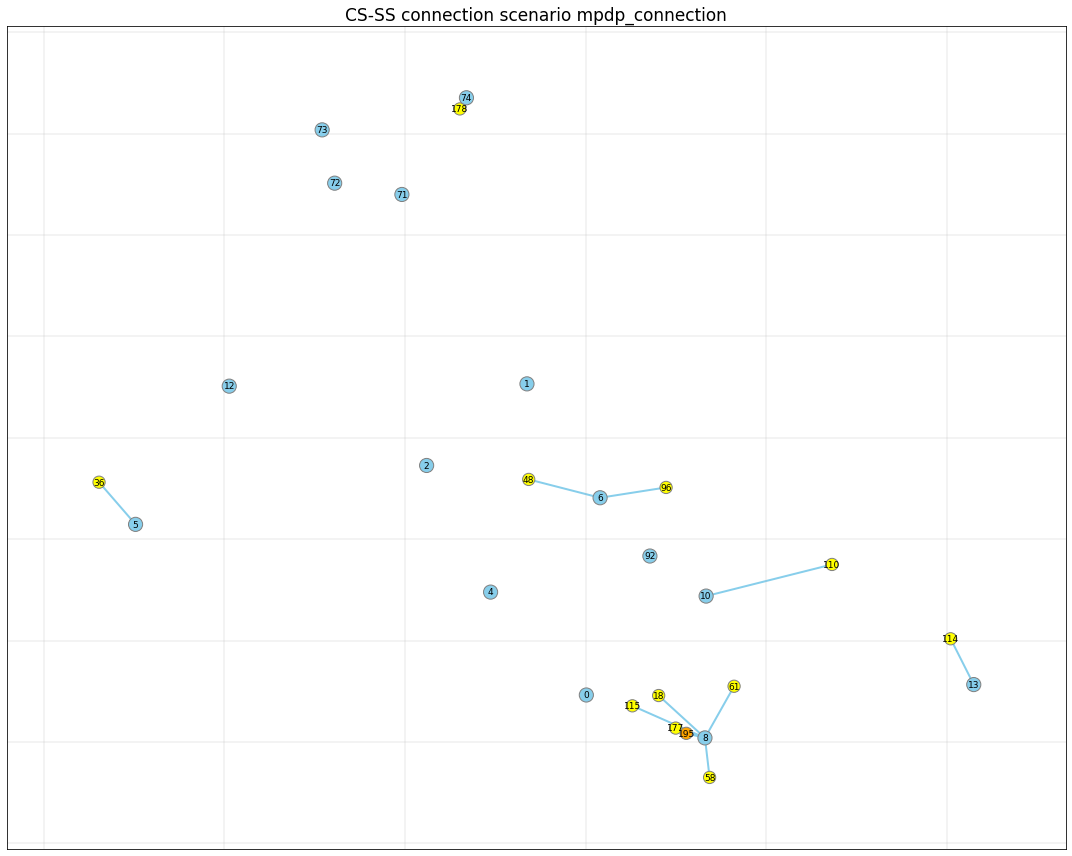

In [147]:
mpdp_connection_dict = {'mpdp_connection': mpdp_connection_sce}
# Sceg.
_plot_cs_ss_connection_graph(
        cs_ss_con_sce_auxi_model, 
        mpdp_connection_dict, 'mpdp_connection'
        )

In [17]:
mpdp_frame_model_4_sp.T.display()

T : Set of time periods.
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    3 : {'day_normal', 'day_peak', 'night'}


In [38]:

def _plot_model_graph(
    model: pyo.ConcreteModel, 
    cd_period: str,
    model_is_solved: bool = False,
    with_label: bool = False,
    save_fig: bool = False
    ) -> None:
    """Extract solved/unsolved model information in dictionary for NetworkX plotting

    Args:
        model (pyo.ConcreteModel): _description_
        model_is_solved (bool, optional): _description_. Defaults to False.
    """
    # import networkx as nx
    # print("Extracting model info")
    ## csap.nodes store the coordinates of nodes by (lat, lon) to make the calculation
    ## of distance easier. But to plot, we need the (lon, lat) form.
    nodes_dict = {key: (list(model.nodes[key])[1], list(model.nodes[key])[0]) \
                     for key in model.nodes.keys() }

    # # Remark: use model.Param.extract_values() to get the dictionary of Pyomo Parameters
    max_extraCP_dict = model.m.extract_values()
    existed_CP_dict = model.n.extract_values()

    # Calculate the static charging demand at a POI j for defining the size of node j.
    # # values of this dictionary are 'pyomo expressions', thus we use the second line 
    # # to evaluate them as numeric values
    mpd_static_POIcd_dict = model.fullcd_POI_static.extract_values() 
    mpd_static_POIcd_dict = {key: evaluate_expression(value) for key,value in mpd_static_POIcd_dict.items()}         
    # # keys of mpd_static_POIcd_dict are (j, t), not valid for NX plotting, which
    # # requires (j). Thus we convert it to pd.df and then use .unstack() to get 
    # # POIcd in different periods.
    mpd_static_POIcd_df = pd.Series(
        data = mpd_static_POIcd_dict, 
        index = mpd_static_POIcd_dict.keys()
        ).unstack()    
    period_static_POIcd_dict = mpd_static_POIcd_df[cd_period].dropna().to_dict()

    # candi_locs_list = list(model.I)

    # CS result dicts
    newBuiltCS_nodes_dict = {id_candiLoc: decision for id_candiLoc, decision in \
        model.x.get_values().items() if id_candiLoc in model.I_newBuild and decision > 1e-10}
    updatedCS_nodes_dict = {id_candiLoc: decision for id_candiLoc, decision in \
        model.x.get_values().items() if id_candiLoc in model.I_update and decision > 1e-10}
    
    # SS result dicts
    expandedSS_nodes_dict = {id_SS: decision for id_SS, decision in \
        model.h.get_values().items() if id_SS in model.K and decision > 1e-10}
    rand_sce_cs_ss_connect_dict = {cs_ss_pair: ob_connected for cs_ss_pair, ob_connected in \
        model.Z.extract_values().items() if ob_connected > 1e-10} 
    
    
    # CD result dicts
    # # solution z is very sparse, thus we only pick nonzero values
    # # Get multiperiod cd supply dict by loading csap solutions of $z$.
    mpd_cd_supply_dict = {cs_cd_pair: assigned_cd for cs_cd_pair, assigned_cd in \
        model.z.get_values().items() if assigned_cd > 1e-10} 
    if mpd_cd_supply_dict == {}:
        period_cd_supply_dict = {}
    # # keys of mpd_cd_supply_dict are (i, j, t), not valid for NX plotting, which
    # # requires (i, j). Thus we convert it to pd.df and then use .unstack() to get 
    # # supply in different periods.
    else:
        mpd_cd_supply_df = pd.Series(
            data = mpd_cd_supply_dict, 
            index = mpd_cd_supply_dict.keys()
            ).unstack()
        period_cd_supply_dict = mpd_cd_supply_df[cd_period].dropna().to_dict()        
    
    # POIarrivals_dict = model.CalA.extract_values()
    
    # Get the walking distance between CSs and a POIs for those 
    # # (cs, poi) pairs with covered charging demands
    total_CS2CD_distance_dict = model.d.extract_values()
    cd_supply_distance_dict = {key: round(pyo.value(total_CS2CD_distance_dict.get(key, None))*60, 1) \
                               for key in period_cd_supply_dict.keys()}
    
    
    ###### Define NetworkX conponents: nodes/edges (sizes, colors)# #####
    # print("Definging graph configurations")
    graph = nx.Graph()
    graph.add_nodes_from(nodes_dict.keys())
    edges_list = [*period_cd_supply_dict.keys(), 
#                   *rand_sce_cs_ss_connect_dict.keys()
                  ]
    graph.add_edges_from(edges_list)
    
    node_colors = [
        'red' if node in newBuiltCS_nodes_dict.keys() else \
        'violet' if node in updatedCS_nodes_dict.keys() else \
        'blue' if node in expandedSS_nodes_dict.keys() else \
        'yellow' if node in model.I_newBuild else \
        'orange' if node in model.I_update else \
        'skyblue' if node in model.K else \
            'lightgray' for node in graph.nodes()
    ]
#     edge_colors = ['green' if (id_candi_loci, cd_or_ss) in period_cd_supply_dict.keys()\
#         else 'skyblue' for (id_candi_loci, cd_or_ss) in graph.edges() # CS-SS connection
#         ]
#     edge_colors = ['green' for (id_candi_loci, cd_or_ss) in graph.edges()]
    edge_colors = 'green'

    size_scaler = 4 # (CS size scalar)
    POI_size_scaler = 0.02
    SS_size = 30
    if model_is_solved:
        node_sizes = [
            # decision on building new CSs
            model.y[node].value*size_scaler if node in newBuiltCS_nodes_dict else \
            # candi_locs to build new CSs that were NOT choosen 
            max_extraCP_dict[node]*size_scaler if node in model.I_newBuild else \
            # decision on updating old CSs
            (model.y[node].value + existed_CP_dict[node])*size_scaler if node in updatedCS_nodes_dict else\
            # candi_locs to update old CSs that were NOT choosen
            existed_CP_dict[node]*size_scaler if node in model.I_update else\
                SS_size if node in model.K else\
            # POIarrivals_dict[node]*4 for node in graph.nodes()
            period_static_POIcd_dict[node]*POI_size_scaler for node in graph.nodes()
        ]
    else:
        node_sizes = [
            max_extraCP_dict[node]*size_scaler if node in model.I_newBuild else \
            (max_extraCP_dict[node] + existed_CP_dict[node])*size_scaler if node in model.I_update else\
                SS_size if node in model.K else\
            # POIarrivals_dict[node]*4 for node in graph.nodes()
            period_static_POIcd_dict[node]*POI_size_scaler for node in graph.nodes()
        ]
    edge_widths = [*(np.array(list(period_cd_supply_dict.values()))*1), 
#                    *(np.array(list(rand_sce_cs_ss_connect_dict.values()))*2)
                   ]
    # for edge,width in zip(edges_list,edge_widths):
    #     print(f"{edge}: {width}")
    
    ##### Plot model graph in NetworkX ##### 
    # print("Plotting ...")
    fig, ax = plt.subplots(figsize=(14,10))
    ax.set_title(label = f'{cd_period} CD coverage', fontsize = 20)
    nx.draw_networkx_nodes(graph, pos=nodes_dict, ax=ax, 
                        node_color=node_colors,
                        edgecolors=  'black', # '#3070B3' (TUM BLUE) ,# '#009999' (SIEMENS GREEN) , #'green',
                        linewidths = 0.3,
                        node_size=node_sizes,
                        )


    nx.draw_networkx_edges(graph, 
                           pos=nodes_dict, 
                           ax=ax, 
                           node_size=300, arrowsize=30,
                           edge_color=edge_colors, 
                           width=edge_widths
                          )
    if with_label:
        nx.draw_networkx_labels(graph, 
                                pos=nodes_dict, ax=ax, 
                                # labels=dict(zip(nodes_dict.keys(), range(0, len(nodes_dict)))),
                                labels=dict(zip(nodes_dict.keys(), nodes_dict.keys())),
                                font_size=5)    
        nx.draw_networkx_edge_labels(graph, pos=nodes_dict, ax=ax, 
                                     edge_labels=cd_supply_distance_dict,
                                     font_size=4, 
                                     rotate=False
                                     )
#     fig.set_facecolor("#00000F00")
    plt.axis('on')
    plt.tight_layout()
    plt.grid(axis = 'both', linewidth=0.3)
    plt.show()
    if save_fig:
        now = datetime.now()
        dt_string = now.strftime("%d%m%Y_%H_%M_%S")
        fig.savefig(dt_string, transparent=True)
    

In [40]:
import networkx as nx

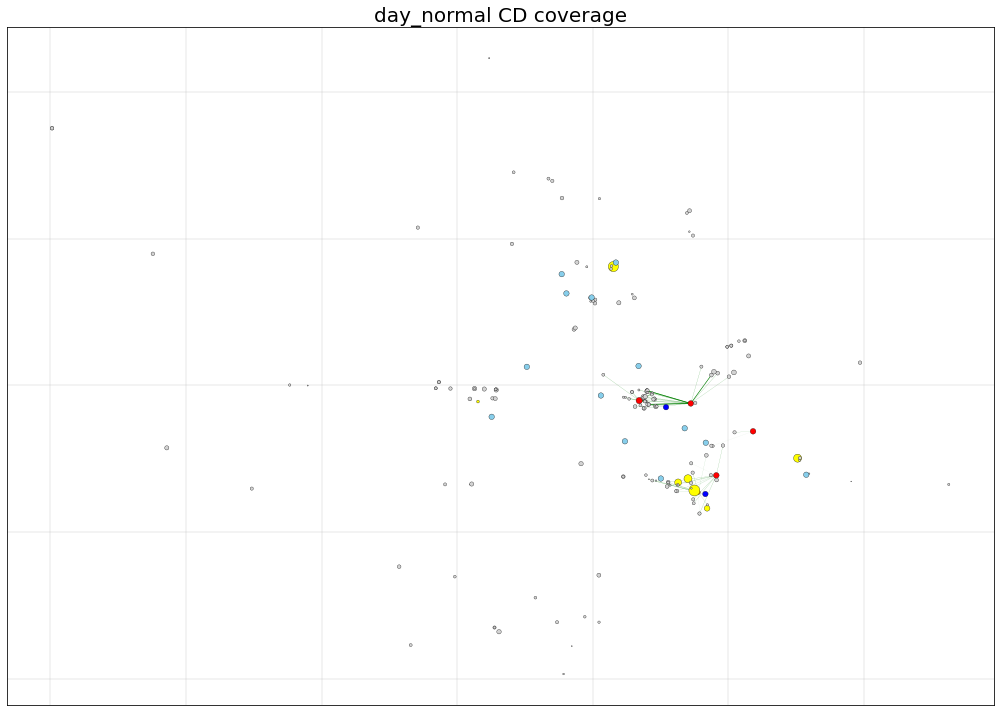

In [41]:
# Dap.
_plot_model_graph(
    model = MPDP_by_frame_data, 
    cd_period = 'day_normal',
    model_is_solved = csap_is_solved,
#     with_label = True
)

In [149]:
test_result_dict

{'obj_total_cost': -446516.2581015142,
 'cs_placement_cost': 163500.0,
 'grid_expansion_cost': 175000.0,
 'backstop_tech_cost_sp': 0.0,
 'gross_revenue': 785016.2581015142,
 'first_stage_cost': -446516.2581015142,
 'prob_description': {'Lower bound': -446516.2581015147,
  'Upper bound': -446516.2581015147,
  'Number of constraints': 3486,
  'Number of variables': 6842},
 'solver_info': {'User time': 0.08,
  'Termination message': 'MIP - Integer optimal solution\\x3a Objective = -4.4651625810e+05',
  'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}},
  'Time': 0.2236342430114746},
 'I_update': [195],
 'I_newBuild': [18, 36, 48, 58, 61, 96, 110, 114, 115, 177, 178],
 'I': [195, 18, 36, 48, 58, 61, 96, 110, 114, 115, 177, 178],
 'J': [15,
  16,
  17,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  49,
  50,
  5

In [152]:
# test_result_dict = Stac._get_data_from_solved_mpdp(
# # test_result_dict = _get_data_from_solved_mpdp(
#     solver_results = test, #results_NO_service_time_cap,
#     solved_model = mpdp_frame_model_4_sp,    
#     )
hourly_CD_cover_each_CP_at_CSs, Nr_CPs = _get_hourly_CD_cover_each_CP_atCSs(mpdp_frame_model_4_sp)
#         Stac._get_hourly_CD_cover_each_CP_atCSs(mpdp_frame_model_4_sp)
wastedESC_df = Stac._get_total_wastedESC_by_parking(mpdp_frame_model_4_sp)
daily_regional_CD_dict = _get_total_regional_CD(mpdp_frame_model_4_sp)
#     Stac._get_total_regional_CD(mpdp_frame_model_4_sp)

In [153]:
wastedESC_df

,day_normal,day_peak,night
18,0.000000,0.000000,0.000000
36,0.000000,0.000000,0.000000
48,935.254180,211.715449,2517.252887
58,467.641605,129.170918,1374.644229
61,935.683391,194.235454,1959.158868
96,853.089001,81.203777,2013.343650
110,896.290786,13.928314,1974.691502
114,1131.496896,464.000000,3465.624114
115,869.765032,283.484592,2999.739817
177,0.000000,0.000000,0.000000


In [35]:
Nr_CPs

36               2
48              10
58               8
61               8
96               8
110              8
114             13
115             12
178             26
195              2
region_total    97
dtype: int64

# Extremly weird wastedESC at 195, which can be >22 kWh/hour?

In [36]:
psi_dict = {key:pyo.value(val) for key, val in mpdp_frame_model_4_sp.psi.extract_values().items()}
psi_df = pd.Series(psi_dict).unstack()
psi_df['Nr_CPs'] = Nr_CPs

In [37]:
w_dict = {key:pyo.value(val) for key, val in mpdp_frame_model_4_sp.w.extract_values().items()}
w_df = pd.Series(w_dict).unstack()
w_df['TESC_normal'] = Nr_CPs*22*22
w_df['TESC_peak'] = Nr_CPs*22*2
w_df['Nr_CPs'] = Nr_CPs

In [38]:
w_df

,day_normal,day_peak,night,TESC_normal,TESC_peak,Nr_CPs
18,0.000000,0.000000,0.000000,NaN,NaN,NaN
36,235.446272,28.917061,17.257909,968.0,88.0,2.0
48,1453.561409,282.362912,89.545677,4840.0,440.0,10.0
58,961.795600,190.192628,90.418363,3872.0,352.0,8.0
61,1058.717397,163.438619,83.679417,3872.0,352.0,8.0
96,1080.272744,209.149990,72.584721,3872.0,352.0,8.0
110,993.264768,109.781780,96.131991,3872.0,352.0,8.0
114,703.842267,93.859748,80.461675,6292.0,572.0,13.0
115,1539.817187,261.289553,128.816649,5808.0,528.0,12.0
177,0.000000,0.000000,0.000000,NaN,NaN,NaN


In [39]:
psi_df

,day_normal,day_peak,night,Nr_CPs
18,0.000000,0.000000,0.000000,NaN
36,235.446272,28.917061,17.257909,2.0
48,1453.561409,186.850010,89.545677,10.0
58,961.795600,151.727862,90.418363,8.0
61,1058.717397,157.863343,83.679417,8.0
96,1080.272744,209.149990,72.584721,8.0
110,960.000000,96.000000,96.131991,8.0
114,703.842267,93.859748,27.483479,13.0
115,1539.817187,246.723516,128.816649,12.0
177,0.000000,0.000000,0.000000,NaN


In [25]:
wastedESC_dict

,normal,peak
18,0.000000,0.000000
36,600.952363,52.883742
48,1873.510659,177.739495
58,2002.268637,198.541493
61,1637.181442,187.315986
96,841.141806,150.751490
110,1344.308118,113.308019
114,0.000000,0.000000
115,2615.480140,286.388322
177,0.000000,0.000000


In [36]:
psi_df['normal'] + wastedESC_dict['normal'],psi_df['peak'] + wastedESC_dict['peak'] 

(18                  0.000000
 36                959.069748
 48               4840.000000
 58               3872.000000
 61               3872.000000
 96               3118.617939
 110              2771.540438
 114                 0.000000
 115              5808.000000
 177                 0.000000
 178             11104.075093
 195              1936.000000
 region_total             NaN
 Name: normal, dtype: float64,
 18                0.000000
 36               85.804117
 48              440.000000
 58              352.000000
 61              352.000000
 96              338.902176
 110             209.308019
 114               0.000000
 115             528.000000
 177               0.000000
 178             981.886494
 195             176.000000
 region_total           NaN
 Name: peak, dtype: float64)

In [27]:
pd.concat([w_df, psi_df, wastedESC_dict], axis = 1)#.divide(Nr_CPs, axis = 0)

,normal,peak,TESC_normal,TESC_peak,Nr_CPs,normal,peak,Nr_CPs,normal,peak
18,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000
36,358.117384,32.920375,968.0,88.0,2.0,358.117384,32.920375,2.0,600.952363,52.883742
48,2966.489341,262.260505,4840.0,440.0,10.0,2966.489341,262.260505,10.0,1873.510659,177.739495
58,1869.731363,153.458507,3872.0,352.0,8.0,1869.731363,153.458507,8.0,2002.268637,198.541493
61,2234.818558,164.684014,3872.0,352.0,8.0,2234.818558,164.684014,8.0,1637.181442,187.315986
96,2277.476133,188.150685,3872.0,352.0,8.0,2277.476133,188.150685,8.0,841.141806,150.751490
110,1495.443689,114.889426,2904.0,264.0,6.0,1427.232320,96.000000,6.0,1344.308118,113.308019
114,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000
115,3192.519860,241.611678,5808.0,528.0,12.0,3192.519860,241.611678,12.0,2615.480140,286.388322
177,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000


In [71]:
def CS_service_time_Cap_rule(model, i, t):             
    service_time_required = pyo.value(sum(
        model.z[i,j,t] * model.tau[i,j] * model.calA[j,t] * (model.calT[j,t]+2*model.d[i,j]) \
            for j in model.J
    ))
    return service_time_required <= pyo.value(model.DeltaT[t]*(model.y[i]+model.n[i]))

In [129]:
# i = 115
i_list = [195] # mpdp_frame_model_4_sp.T
print(pyo.value(mpdp_frame_model_4_sp.y[i]+mpdp_frame_model_4_sp.n[i]))
for i in i_list:
    for t in mpdp_frame_model_4_sp.T:
        print(f'EESC {i}: {pyo.value(mpdp_frame_model_4_sp.w[i,t])}')
        print(f"served energy {i}: {pyo.value(mpdp_frame_model_4_sp.psi[i,t])}")
        for j in mpdp_frame_model_4_sp.J:
            char_frac = pyo.value(mpdp_frame_model_4_sp.z[i,j,t])
            if char_frac > 1e-5:
                print(f'{j},{t}: {char_frac}')
                print(f"tau: {pyo.value(mpdp_frame_model_4_sp.tau[i,j])}")
                print(f"NumArrivals: {mpdp_frame_model_4_sp.calA[j, t]}")
                char_val = pyo.value(mpdp_frame_model_4_sp.z[i,j,t] * \
                                mpdp_frame_model_4_sp.calA[j, t] * mpdp_frame_model_4_sp.tau[i,j])
                dur = pyo.value(mpdp_frame_model_4_sp.calT[j,t]+ 2*mpdp_frame_model_4_sp.d[i,j])
                print(f"Visiting Dur: {dur}")
                print(f"SOC: {pyo.value(mpdp_frame_model_4_sp.delta[j,t])}")
                print(f"CD: {pyo.value(mpdp_frame_model_4_sp.calD[i,j,t])}")
                print(f"WastedESC: {pyo.value(mpdp_frame_model_4_sp.pi * dur - mpdp_frame_model_4_sp.calD[i, j,t])}")
                print(f"Satisfied Num Arrivals: {char_val}\n")
#         print(f'service_time_rule: {CS_service_time_Cap_rule(mpdp_frame_model_4_sp, i, t)}')

4.0
EESC 195: 1019.8825324427957
served energy 195: 1013.6708649270415
47,normal: 0.3019142044171018
tau: 0.9739076822428792
NumArrivals: 75.0
Visiting Dur: 0.40302303741695916
SOC: 0.8973280843579863
CD: 4.517564288248604
WastedESC: 4.348942534924499
Satisfied Num Arrivals: 22.052742229504684

84,normal: 0.9544172978467607
tau: 0.9928528001746368
NumArrivals: 73.0
Visiting Dur: 0.5625360258181614
SOC: 0.8983543684899269
CD: 4.472407786443217
WastedESC: 7.903384781556335
Satisfied Num Arrivals: 69.17449972926546

159,normal: 0.9444803463862593
tau: 0.9977503590233757
NumArrivals: 79.0
Visiting Dur: 0.4144218279534039
SOC: 0.828190039446082
CD: 7.55963826437239
WastedESC: 1.5576419506024948
Satisfied Num Arrivals: 74.44609277109559

189,normal: 0.10094559348071072
tau: 0.9988892969767141
NumArrivals: 147.0
Visiting Dur: 0.6305946965441804
SOC: 0.935779414832843
CD: 2.8257057473549083
WastedESC: 11.04737757661706
Satisfied Num Arrivals: 14.822520517012114

EESC 195: 81.92225338596175
ser

In [61]:
hourly_CD_cover_each_CP_at_CSs

,normal,peak
36,7.986727,5.714913
48,14.027979,12.456360
58,9.462292,8.661968
61,11.801558,9.248745
96,9.760525,9.179550
110,8.786773,8.720717
114,4.938573,9.907458
115,11.378732,11.546170
178,7.105194,6.433422
195,10.663542,8.080131


In [32]:
# pyo.value(mpdp_frame_model_4_sp.calT[159, 'normal'])
pyo.value(mpdp_frame_model_4_sp.pi * (mpdp_frame_model_4_sp.calT[159, 'normal']+2*mpdp_frame_model_4_sp.d[195,159]))
pyo.value((1-mpdp_frame_model_4_sp.delta[159,'normal'])*44)

7.55963826437239

In [33]:
mpdp_frame_model_4_sp.calD[195,159,'normal'].pprint()

{Member of calD} : CD of a single arrival at CS i ∈ I raised by a visiting to POI j ∈ J during t ∈ T.
    Size=3792, Index=calD_index
    Key                  : Expression
    (195, 159, 'normal') : 7.55963826437239


In [86]:
pyo.value(mpdp_frame_model_4_sp.calD[195, 84, 'normal']), pyo.value(mpdp_frame_model_4_sp.calD[195, 189, 'normal'])

(8.547914001004461, 0.4241127012028958)

In [108]:
(pyo.value(mpdp_frame_model_4_sp.calT[84, 'normal'])*22, pyo.value(mpdp_frame_model_4_sp.calT[189, 'normal'])*22)

(14.07865535794443, 11.285716274915167)

In [105]:
pyo.value(mpdp_frame_model_4_sp.calA[84, 'normal']), pyo.value(mpdp_frame_model_4_sp.calA[189, 'normal'])

(99.0, 116.0)

In [130]:
import plotly.express as px
# from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_phi_IJ_total_hourlyCD_Cover(
    df_1CP_CD_cov: pd.DataFrame,
    df_Nr_CPs: pd.DataFrame,
    plot_type: str = 'histo',
    plot_name: str = 'Name of Graph'
    ):
    df_1CP_CD_cov_copy = df_1CP_CD_cov.copy()
    columns = df_1CP_CD_cov_copy.columns
#     df_copy['sum'] = df_copy.sum(axis=1)
    # wide_df['phi_II'] = [4/60, 5/60,7/60]
    plot_labels = {
        'x': 'Grid Period', 
        'y': 'Connections'
#         **{str(col): f"CS {col}" for col in columns}, #'Number of CS-SS Connections',
#         
    }
    
    if plot_type == 'histo':
        fig = px.histogram(
            df_1CP_CD_cov_copy, x=df_1CP_CD_cov_copy.index.astype(str), 
            y=columns, 
#             facet_col = columns,
#             title=plot_name, 
#             text_auto = True,
            barmode = 'relative', #str (default `'relative'`) 'group', 'overlay' or 'relative'
            orientation = 'v',
            cumulative = False,
            labels = plot_labels
            # marginal = "histogram",
            # marginal_y = "violin",
            # opacity = 0.7,                       
        )
#     print(plot_labels)

#         trace_cols_of_interest = ['sum']
#         for col in cols_of_interest:
        fig.add_trace(
             go.Scatter(
        #          wide_df,
                x=df_1CP_CD_cov.index, 
                y=df_1CP_CD_cov.sum(axis = 1), 
#                 mode="lines",
#                 line=go.scatter.Line(
#                  color="gray"
#              ),
                showlegend=True,
#                  opacity = 0.7,
                 name = f'Sum',
             )
        )


    fig.update_layout(legend=dict(
        orientation="v",
        yanchor="auto",
        y=1.00,
        xanchor="auto",
        x=1.15
        ),
        plot_bgcolor = 'rgba(0,0,0,0.05)',
      legend_title_text='CS ID (Nr. CPs)',
          title={
        'text': plot_name,
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
     )
    fig.show()


### Test for phi_IJ in [0,8] (TODO by 05.Dec)

In [51]:

Solver = SolverFactory(
#     'glpk'
#     'ipopt'
    'cplex'
#     'gams'
#     'cplex_direct'
#     'bonmin'
    # 'couenne'
    , tee = True, 
)

for eta_value in np.arange(1.35, 1.55, 0.07):
    print('---------------------------')
    mpdp_test_m.c_eta = eta_value
    test_results = Solver.solve(mpdp_test_m)
    csap_is_solved = True
    opt_val_message = test_results['Solver'][0]['Termination message']
    print(f"Results of c_eta = {eta_value} is: {opt_val_message}")
    # print(f"Results for \n", test_results)
    print_decision = True
    if print_decision:
        Stac._print_decision(mpdp_test_m)
    print('---------------------------')
    
# Dap._plot_model_graph(
#     model = mpdp_test_m, 
#     cd_period = 'normal',
#     model_is_solved = csap_is_solved
# )


---------------------------
Results of c_eta = 1.35 is: MIP - Integer optimal, tolerance (0.0001/1e-06)\x3a Objective = -1.7304342244e+06
Decision to build new CSs, 
(loc_id, Nr_CP): 
[(48, 10.0), (58, 8.0), (61, 8.0), (96, 8.0), (110, 8.0), (114, 7.0), (115, 12.0), (178, 26.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_CPs): 
[(195, 2.0, 4.0)]
Decision to expand SSs, 
(loc_id, size_expansion): 
[]

Decision to use expensive backstop tech at SSs, 
((loc_id, period), amount_backstop usage): 
[((6, 'peak'), 119.0), ((8, 'peak'), 185.0), ((10, 'peak'), 46.0), ((13, 'peak'), 24.0), ((74, 'peak'), 118.0)]

---------------------------
---------------------------
Results of c_eta = 1.4200000000000002 is: MIP - Integer optimal, tolerance (0.0001/1e-06)\x3a Objective = -1.7268672244e+06
Decision to build new CSs, 
(loc_id, Nr_CP): 
[(48, 10.0), (58, 8.0), (61, 8.0), (96, 8.0), (110, 8.0), (114, 7.0), (115, 12.0), (178, 26.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_C

In [31]:
# with open('dict_mpsp_convergency_test_24Nov_abs5test.pickle', 'wb') as f:
#     pickle.dump(dict_mpsp_c_test_abs5, f)        

dict_mpsp_c_test_abs5

{1: {'num_scenarios': 1,
  'ids_scenarios': array(['3353'], dtype='<U5'),
  'objective_value': -1767717.1501209545,
  'prob_description': {'Lower bound': -1767717.1501209545,
   'Upper bound': -1767717.1501209545,
   'Number of constraints': 3167,
   'Number of variables': 6706},
  'solver_info': {'User time': 0.28,
   'Termination message': 'MIP - Integer optimal solution\\x3a Objective = -1.7677171501e+06',
   'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}},
   'Time': 0.568152904510498},
  'gap': 0.0,
  'mpsp_csap_decisions': {}},
 2: {'num_scenarios': 21,
  'ids_scenarios': array(['5112', '7865', '4334', '3618', '7218', '5238', '9605', '2601',
         '8508', '2205', '2983', '2732', '4271', '2466', '5217', '1640',
         '5009', '5256', '7952', '13', '4904'], dtype='<U5'),
  'objective_value': -1199581.2114090582,
  'prob_description': {'Lower bound': -1199617.8776,
   'Upper bound': -1199581.2114090582,
   'Number of 

In [ ]:
        ## Store results in the dict
        print("Storing test results ... ")
        results_prob_descrip = results['Problem'][0]
        results_solver_info = results['Solver'][0]
        current_obj_val = results['Solution'][0]['Objective']['__default_objective__']['Value']
        
        if SP == True:
            csap_subsces = csap_ef.scenarios()
            subsce_name, subscemodel = next(csap_subsce)
            SP_one_subscemodel_data = SupSP._get_data_from_frame_model(frame_model = subscemodel)
        else:
            model_data = SupSP._get_data_from_frame_model(frame_model = model)
        ## Store CSAP decisions

        test_result_dict[test_id] = {
            'num_scenarios': num_sces,
            'ids_scenarios': selected_sces_names,
            'objective_value' : current_obj_val,
            'prob_description': {key: results_prob_descrip[key] for key in useful_description_info_list },
            'solver_info' : {key: results_solver_info[key] for key in useful_solver_info_list},
            'gap' : results['Solution'][0]['Gap'], 
            'one_subsceModel_data' : SP_one_subscemodel_data
            # 'mpsp_csap_decisions': mpsp_decisions 
        }
        print('Done\n---------------------------------------\n')

In [3]:
# copy_csap_setup_dict = csap_setup_dict.copy() 
mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')
solved_frame_model_data = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_5_SP_converge_test_3PD\solved_frame__data.pickle')
# SAA_convergence_test_results = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_2_phi_IJ_walk_dist_2_charge\sces500_convergency_test_0412_test.pickle')
# with open('0412_sces500_convergence_another_test_frame_model_data.pickle', 'wb') as f:
#     pickle.dump(frame_model_data, f)
# # frame_model_data
# unsolved_frame_model_data
all_connection_sces_dict = generated_scenarios

In [4]:
NrCPs_list = [n for n in range(10, 110, 10)]
NrCPs_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [5]:
solved_frame_model_data['N_newCPs']

{None: 80}

In [4]:
selected_sces_names = ['15877', '18654', '18313', '8924', '19775', '14033', '1237',
        '7857', '140', '12205', '4633', '8100', '4372', '14050', '3203',
        '14557', '10548', '2261', '8008', '16453', '3667', '759', '13860',
        '11167', '19969', '10058', '2608', '18522', '18113', '10629',
        '19408', '18799', '12707', '15576', '5914', '8445', '19341',
        '4056', '10228', '13678', '18756', '1211', '16720', '10900',
        '5744', '2030', '19194', '9465', '9151', '12063', '19232', '12818',
        '18815', '4451', '18906', '9796', '11227', '3361', '18793', '2407',
        '12346', '16832', '4673', '14188', '2415', '18659', '8178', '7258',
        '10960', '8509', '14154', '5338', '14349', '12683', '6473',
        '18661', '4582', '11736', '10576', '19590', '9846', '3272', '7218',
        '2235', '17544', '12483', '14649', '12907', '6276', '14447',
        '12379', '3032', '6315', '10936', '15433', '9487', '14569',
        '17046', '7602', '1060', '15516', '4904', '17417', '3866', '2929',
        '18319', '4043', '19695', '8142', '17641', '8833', '15058', '99',
        '12659', '4239', '16560', '16384', '1278', '3382', '1161', '12481',
        '14573', '18943', '604', '19412', '9398', '5755', '6085', '16479',
        '17473', '19393', '14885', '19119', '15935', '4494', '15188',
        '1770', '17624', '12257', '4236', '8949', '13046', '18511', '6526',
        '1473', '19424', '6750', '11406', '18043', '11960', '6354',
        '12790', '18924', '11862', '8048', '9892', '6893', '10686', '2306',
        '7953', '17519', '9281', '13788', '6619', '900', '3649', '10116',
        '8673', '17752', '5427', '8021', '16987', '11315', '13877', '2497',
        '3870', '14869', '18947', '6573', '3552', '15240', '949', '15393',
        '5176', '3364', '2100', '3784', '5782', '5640', '5699', '14974',
        '17621', '12849', '15087', '8293', '1424', '10554', '10674',
        '2113', '4545', '6944']
selected_connection_sces_dict = dict((key, all_connection_sces_dict[key]) for key in selected_sces_names)


In [6]:
# selected_sces_names = ['1']
# selected_connection_sces_dict = dict((key, all_connection_sces_dict[key]) for key in selected_sces_names)


In [5]:
num_threads = 2
print(f"num_threads: {num_threads}")
solver_options = {"solver": "cplex",
    "threads": num_threads,
    "warmstart": True
}

NrCPs_list = [n for n in range(80, 110, 10)]
# NrCPs_list = [70]
# NrCPs_list = [80]
# NrCPs_list = [90]
# NrCPs_list = [100]

# NrCPs_list = [n for n in range(10, 30, 10)]
# str_phi_IJ_list = [f'{i}/60' for i in range(3,11)]
# float_phi_IJ_list = [i/60 for i in range(3,11)]
MPSP_NrCPs_test_dict = dict()
last_time = time.perf_counter() # Used for check point save
error_exists = False

for idx, NrCPs in enumerate(NrCPs_list):
    print('---------------------------')
    print(f"NrCPs = {NrCPs} test starts ... ")
    solved_frame_model_data['N_newCPs'] = NrCPs
    model_name = 'NrCPs_test_MPSP_by_frame_data' # assign name to pyomo model, default name set in the setup function is 'CSAP'
    csap_is_solved = False
    linearize_csap = True

    try:
        tic = time.perf_counter()
        print(f"""Building Stochastic Model with {len(selected_connection_sces_dict)} Scenarios. 
            You will see {len(selected_connection_sces_dict)} times the same model set-up message. \n""")
        csap_ef = ExtensiveForm(options = solver_options, 
            all_scenario_names = selected_sces_names, 
            scenario_creator = Sceg.csap_scenario_creator,
            scenario_creator_kwargs = {
                "mpdp_frame_data": solved_frame_model_data,
                "all_sces_dict": selected_connection_sces_dict,
            }
        )
        toc = time.perf_counter()
        print(f"Succeed! SP Model set-up took {round(toc - tic,2)} seconds in total.\n")    

        print('Solving MPS-MILP')        
        tic = time.perf_counter()
        solver_results = csap_ef.solve_extensive_form()
        current_obj_val = solver_results['Solution'][0]['Objective']['__default_objective__']['Value']        
        toc = time.perf_counter()
        print(f"  Done! It took {round(toc - tic, 2)} seconds to solve the extensive form of SP. \n")    
    

        ## Store results in the dict
        print("Storing test results in dict ... ")
        MPSP_NrCPs_test_dict[NrCPs] = Stac._get_data_from_solved_MPSP(
            ef_solver_results = solver_results,
            solved_MPSP_extensive_form = csap_ef,    
            num_scenarios = len(selected_sces_names),
            ids_scenarios = selected_sces_names,
            )
        print('Done\n---------------------------------------\n')

    except Exception as e:
        error_exists = True
        print(f"Got error with NrCPs {NrCPs}")
        print(e)
        MPSP_NrCPs_test_dict['Stop'] = str(e)
        with open('Exception_MPSP_NrCPs_test_80_100.pickle', 'wb') as f:
            pickle.dump(MPSP_NrCPs_test_dict, f)
        print('Saved test results as .pickle file under Exception and Stopped')
        break
    current_time = time.perf_counter()
    if current_time - last_time > 900:
        with open(f'MPSP_NrCPs_test_temp_save_80_100.pickle', 'wb') as f:
            pickle.dump(MPSP_NrCPs_test_dict, f)        
        print(f'More than 900 seconds passed, save results so far till NrCPs {NrCPs} in a .pickle file, test continues')
        last_time = current_time
    


if not error_exists:
#     SAA_convergence_test_dict['Stop'] = f'Solved all scenarios'
    with open('MPSP_NrCPs_test_dict_80_100.pickle', 'wb') as f:
        pickle.dump(MPSP_NrCPs_test_dict, f)        
    print('Savevd Results as .pickle file, Convergence Test Done')    
    
    

num_threads: 2
---------------------------
NrCPs = 80 test starts ... 
Building Stochastic Model with 201 Scenarios. 
            You will see 201 times the same model set-up message. 

[   56.81] Initializing SPBase
Done! set up EVCSAP_MPSP took 1.64 seconds.
Done! set up EVCSAP_MPSP took 1.47 seconds.
Done! set up EVCSAP_MPSP took 1.76 seconds.
Done! set up EVCSAP_MPSP took 1.64 seconds.
Done! set up EVCSAP_MPSP took 1.05 seconds.
Done! set up EVCSAP_MPSP took 1.84 seconds.
Done! set up EVCSAP_MPSP took 1.53 seconds.
Done! set up EVCSAP_MPSP took 1.23 seconds.
Done! set up EVCSAP_MPSP took 1.19 seconds.
Done! set up EVCSAP_MPSP took 1.64 seconds.
Done! set up EVCSAP_MPSP took 1.71 seconds.
Done! set up EVCSAP_MPSP took 1.03 seconds.
Done! set up EVCSAP_MPSP took 1.55 seconds.
Done! set up EVCSAP_MPSP took 0.99 seconds.
Done! set up EVCSAP_MPSP took 0.96 seconds.
Done! set up EVCSAP_MPSP took 1.82 seconds.
Done! set up EVCSAP_MPSP took 1.0 seconds.
Done! set up EVCSAP_MPSP took 1.06 s

Done! set up EVCSAP_MPSP took 1.06 seconds.
Done! set up EVCSAP_MPSP took 1.11 seconds.
Done! set up EVCSAP_MPSP took 1.05 seconds.
Done! set up EVCSAP_MPSP took 1.35 seconds.
Done! set up EVCSAP_MPSP took 1.31 seconds.
Done! set up EVCSAP_MPSP took 1.4 seconds.
Done! set up EVCSAP_MPSP took 1.44 seconds.
Done! set up EVCSAP_MPSP took 1.15 seconds.
Done! set up EVCSAP_MPSP took 1.17 seconds.
Done! set up EVCSAP_MPSP took 1.36 seconds.
Done! set up EVCSAP_MPSP took 1.6 seconds.
Done! set up EVCSAP_MPSP took 1.82 seconds.
Done! set up EVCSAP_MPSP took 1.58 seconds.
Done! set up EVCSAP_MPSP took 2.09 seconds.
Done! set up EVCSAP_MPSP took 1.86 seconds.
Done! set up EVCSAP_MPSP took 1.61 seconds.
Done! set up EVCSAP_MPSP took 2.1 seconds.
Done! set up EVCSAP_MPSP took 1.81 seconds.
Done! set up EVCSAP_MPSP took 2.11 seconds.
Succeed! SP Model set-up took 314.41 seconds in total.

Solving MPS-MILP
  Done! It took 382.61 seconds to solve the extensive form of SP. 

Storing test results in di

Done! set up EVCSAP_MPSP took 1.18 seconds.
Done! set up EVCSAP_MPSP took 1.12 seconds.
Done! set up EVCSAP_MPSP took 1.03 seconds.
Done! set up EVCSAP_MPSP took 1.03 seconds.
Done! set up EVCSAP_MPSP took 1.0 seconds.
Done! set up EVCSAP_MPSP took 0.98 seconds.
Done! set up EVCSAP_MPSP took 0.98 seconds.
Done! set up EVCSAP_MPSP took 1.15 seconds.
Done! set up EVCSAP_MPSP took 0.98 seconds.
Done! set up EVCSAP_MPSP took 1.34 seconds.
Done! set up EVCSAP_MPSP took 0.99 seconds.
Done! set up EVCSAP_MPSP took 1.19 seconds.
Done! set up EVCSAP_MPSP took 1.01 seconds.
Done! set up EVCSAP_MPSP took 0.97 seconds.
Done! set up EVCSAP_MPSP took 1.02 seconds.
Done! set up EVCSAP_MPSP took 0.96 seconds.
Done! set up EVCSAP_MPSP took 1.35 seconds.
Done! set up EVCSAP_MPSP took 1.0 seconds.
Done! set up EVCSAP_MPSP took 1.02 seconds.
Done! set up EVCSAP_MPSP took 0.99 seconds.
Done! set up EVCSAP_MPSP took 1.03 seconds.
Done! set up EVCSAP_MPSP took 0.99 seconds.
Done! set up EVCSAP_MPSP took 0.9 

Done! set up EVCSAP_MPSP took 1.01 seconds.
Done! set up EVCSAP_MPSP took 1.16 seconds.
Done! set up EVCSAP_MPSP took 1.1 seconds.
Done! set up EVCSAP_MPSP took 0.96 seconds.
Done! set up EVCSAP_MPSP took 1.0 seconds.
Done! set up EVCSAP_MPSP took 0.93 seconds.
Done! set up EVCSAP_MPSP took 0.96 seconds.
Done! set up EVCSAP_MPSP took 0.97 seconds.
Done! set up EVCSAP_MPSP took 0.97 seconds.
Done! set up EVCSAP_MPSP took 0.96 seconds.
Done! set up EVCSAP_MPSP took 0.96 seconds.
Done! set up EVCSAP_MPSP took 0.95 seconds.
Done! set up EVCSAP_MPSP took 0.97 seconds.
Done! set up EVCSAP_MPSP took 0.96 seconds.
Done! set up EVCSAP_MPSP took 1.18 seconds.
Done! set up EVCSAP_MPSP took 0.96 seconds.
Done! set up EVCSAP_MPSP took 1.37 seconds.
Done! set up EVCSAP_MPSP took 1.31 seconds.
Done! set up EVCSAP_MPSP took 1.0 seconds.
Done! set up EVCSAP_MPSP took 1.05 seconds.
Done! set up EVCSAP_MPSP took 0.95 seconds.
Done! set up EVCSAP_MPSP took 0.97 seconds.
Done! set up EVCSAP_MPSP took 0.99 

In [20]:
MPSP_NrCPs_test_dict.keys()

dict_keys([10, 20])

In [7]:
NrCPs_MPSP_Dict = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_3_NrCPs_budget\MPSP_NrCPs_test_dict_10_20.pickle')
NrCPs_MPSP_Dict_30_60 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_3_NrCPs_budget\MPSP_NrCPs_test_dict_10_20.pickle')


In [15]:
NrCPs_MPSP_Dict_80_100 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_3_NrCPs_budget\MPSP_NrCPs_test_dict_80_100.pickle')

In [16]:
for key,item in NrCPs_MPSP_Dict_80_100.items():
    NrCPs_MPSP_Dict[key] = item

In [17]:
NrCPs_MPSP_Dict.keys()

dict_keys([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [27]:
NrCPs_MPSP_Dict[10]


{'num_scenarios': 201,
 'ids_scenarios': ['15877',
  '18654',
  '18313',
  '8924',
  '19775',
  '14033',
  '1237',
  '7857',
  '140',
  '12205',
  '4633',
  '8100',
  '4372',
  '14050',
  '3203',
  '14557',
  '10548',
  '2261',
  '8008',
  '16453',
  '3667',
  '759',
  '13860',
  '11167',
  '19969',
  '10058',
  '2608',
  '18522',
  '18113',
  '10629',
  '19408',
  '18799',
  '12707',
  '15576',
  '5914',
  '8445',
  '19341',
  '4056',
  '10228',
  '13678',
  '18756',
  '1211',
  '16720',
  '10900',
  '5744',
  '2030',
  '19194',
  '9465',
  '9151',
  '12063',
  '19232',
  '12818',
  '18815',
  '4451',
  '18906',
  '9796',
  '11227',
  '3361',
  '18793',
  '2407',
  '12346',
  '16832',
  '4673',
  '14188',
  '2415',
  '18659',
  '8178',
  '7258',
  '10960',
  '8509',
  '14154',
  '5338',
  '14349',
  '12683',
  '6473',
  '18661',
  '4582',
  '11736',
  '10576',
  '19590',
  '9846',
  '3272',
  '7218',
  '2235',
  '17544',
  '12483',
  '14649',
  '12907',
  '6276',
  '14447',
  '12379',

In [32]:
NrCPs_MPSP_Dict.keys()

dict_keys([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [48]:
data_of_interest = dict()
for key, item in NrCPs_MPSP_Dict.items():
    data_of_interest[key] = dict()
#     print(f"obj of {key} CPs: {item['objective_value']}")
#     print(f"installed CPs: {item['mpsp_csap_decisions']['y']}")
    subdict_model_key = list(item.keys())[-1]
    sub_model_data = item[subdict_model_key]
#     print(f"cs_placement_cost: {sub_model_data['cs_placement_cost']}")
#     print(f"grid_expansion_cost: {sub_model_data['grid_expansion_cost']}")
#     print(f"gross_revenue: {sub_model_data['gross_revenue']}")
    data_of_interest[key]['objective_value'] = item['objective_value']
    data_of_interest[key]['y'] = item['mpsp_csap_decisions']['y']
    data_of_interest[key]['cs_placement_cost'] = sub_model_data['cs_placement_cost']
    data_of_interest[key]['grid_expansion_cost'] = sub_model_data['grid_expansion_cost']
    data_of_interest[key]['gross_revenue'] = sub_model_data['gross_revenue']
    

In [39]:
pd.DataFrame(data_of_interest).T

,objective_value,y,cs_placement_cost,grid_expansion_cost,gross_revenue
10,315519.840679,"{'48': 3.0, '58': 3.0, '110': 4.0}",31500.0,0.0,348835.761077
20,511996.581876,"{'36': 2.0, '48': 4.0, '58': 3.0, '61': 1.0, '...",63000.0,25000.0,627235.387847
30,673298.956181,"{'36': 2.0, '48': 5.0, '58': 4.0, '61': 1.0, '...",88500.0,25000.0,824479.30444
40,817221.482065,"{'36': 2.0, '48': 5.0, '58': 8.0, '61': 5.0, '...",111000.0,125000.0,1110422.974602
50,951976.457691,"{'36': 2.0, '48': 6.0, '58': 8.0, '61': 5.0, '...",136500.0,225000.0,1376125.711422
60,1084971.581963,"{'36': 2.0, '48': 6.0, '58': 8.0, '61': 8.0, '...",159000.0,275000.0,1625656.905346
70,1146109.046938,"{'48': 6.0, '58': 8.0, '61': 8.0, '96': 8.0, '...",181500.0,300000.0,1738834.171316
80,1179035.82462,"{'48': 7.0, '58': 8.0, '61': 8.0, '96': 8.0, '...",199500.0,350000.0,1838399.0087
90,1191451.971244,"{'48': 10.0, '58': 8.0, '61': 8.0, '96': 8.0, ...",222000.0,500000.0,2076884.807064
100,1191451.971244,"{'48': 10.0, '58': 8.0, '61': 8.0, '96': 8.0, ...",222000.0,500000.0,2076884.807064


In [40]:
NrCPs_MPDP = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_3_NrCPs_budget\Nr_CPs_test_results_dict_1001_MPDP.pickle')

In [57]:
NrCPs_MPDP['NrCPs_10'].keys()#['N_Nr']

dict_keys(['obj_total_cost', 'cs_placement_cost', 'grid_expansion_cost', 'backstop_tech_cost_sp', 'gross_revenue', 'first_stage_cost', 'prob_description', 'solver_info', 'solved_model_data'])

In [60]:
### MPDP_data_of_interest = dict()
for key, item in NrCPs_MPDP.items():
    MPDP_data_of_interest[key] = dict()
# #     print(f"obj of {key} CPs: {item['objective_value']}")
# #     print(f"installed CPs: {item['mpsp_csap_decisions']['y']}")
#     subdict_model_key = list(item.keys())[-1]
#     sub_model_data = item[subdict_model_key]
# #     print(f"cs_placement_cost: {sub_model_data['cs_placement_cost']}")
# #     print(f"grid_expansion_cost: {sub_model_data['grid_expansion_cost']}")
# #     print(f"gross_revenue: {sub_model_data['gross_revenue']}")
#     data_of_interest[key]['objective_value'] = item['objective_value']
#     data_of_interest[key]['y'] = item['mpsp_csap_decisions']['y']
    MPDP_data_of_interest[key]['obj_profit'] = -item['obj_total_cost']
    MPDP_data_of_interest[key]['cs_placement_cost'] = item['cs_placement_cost']
    MPDP_data_of_interest[key]['grid_expansion_cost'] = item['grid_expansion_cost']
    MPDP_data_of_interest[key]['gross_revenue'] = item['gross_revenue']
#     obj_total_cost

In [61]:
pd.DataFrame(MPDP_data_of_interest).T

,obj_profit,cs_placement_cost,grid_expansion_cost,gross_revenue
NrCPs_10,3.245046e+05,31500.0,0.0,3.560046e+05
NrCPs_20,5.576177e+05,57000.0,50000.0,6.646177e+05
NrCPs_30,7.817764e+05,79500.0,100000.0,9.612764e+05
NrCPs_40,9.896724e+05,105000.0,150000.0,1.244672e+06
NrCPs_50,1.192711e+06,133500.0,200000.0,1.526211e+06
NrCPs_60,1.374906e+06,161500.0,250000.0,1.786406e+06
NrCPs_70,1.510061e+06,184000.0,275000.0,1.969061e+06
NrCPs_80,1.621546e+06,206500.0,300000.0,2.128046e+06
NrCPs_90,1.715080e+06,232000.0,300000.0,2.247080e+06
NrCPs_100,1.770332e+06,254500.0,375000.0,2.399832e+06
